In [376]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [377]:
df = pd.read_csv('../data/player_stats_trends.csv')
tournament_stats = pd.read_csv('../data/tournament_stats.csv')
goals = pd.read_csv('../data/goals.csv')
awards = pd.read_csv('../data/awards.csv')

In [378]:
awards['Year'] = awards['Season'].apply(lambda x: float(str(x)[-2:]))
awards = awards.drop(columns=['Season', 'Club/Country'])
awards = awards.groupby('Award').filter(lambda x: len(x) >= 5)
awards = awards[~awards['Award'].isin(["Winner Ballon d'Or", 'Footballer of the Year', 'UEFA Best Player in Europe', "The Best FIFA Men's Player", 'Player of the Year', 'Top goal scorer', 'African Footballer of the Year', 'TM-Player of the season'])]

awards = pd.get_dummies(awards, columns=['Award'], prefix='', prefix_sep='')

for col in awards.columns:
    if col not in ['Player', 'Year']:
        awards[col] = awards[col].astype(int)
awards = awards.groupby(['Player', 'Year']).sum().reset_index()


In [379]:
def goal_fixer(goals):
    try:
        return int(goals)
    except:
        return 0
def run_model(X, y):
    glm = sm.GLM(endog=y, exog= X, family=sm.families.Gaussian())
    X = sm.add_constant(X)
    glm_results = glm.fit()
    return glm_results
def remove_p(X, glm_results, p):
    to_remove = []
    for i in glm_results.pvalues.index:
        if glm_results.pvalues[i] > p:
            to_remove.append(i)
        elif np.isnan(glm_results.pvalues[i]):
            to_remove.append(i)
    X = X.drop(columns=to_remove)
    return X

In [380]:
tournament_stats['Year'] = tournament_stats['Season'].apply(lambda x: float(x[-2:]))
tournament_stats = tournament_stats.drop('Season', axis=1)
tournament_stats = tournament_stats.query('Year >= 8 & Year <= 23')
tournament_stats['Goals'] = tournament_stats['Goals'].apply(lambda x: goal_fixer(x))
tournament_stats['Minutes played']= tournament_stats['Minutes played'].str.replace("'", '').str.replace('.', '')
for col in tournament_stats.columns:
    if col not in ['Player', 'Competition', 'Club', 'Year']:
        try:
            tournament_stats[col] = tournament_stats[col].str.replace('-', '0').astype(float)
        except:
            pass 

comp_goals = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Goals'].replace(np.nan, 0).reset_index()
comp_goals = comp_goals.rename(columns=lambda x: x + '_Goals')
comp_goals.rename(columns={'Year_Goals': 'Year', 'Player_Goals' : 'Player'}, inplace=True)

comp_ass = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Assists'].replace(np.nan, 0).reset_index()
comp_ass = comp_ass.rename(columns=lambda x: x + '_ass')
comp_ass.rename(columns={'Year_ass': 'Year', 'Player_ass' : 'Player'}, inplace=True)

Goals = []
for i in comp_goals.iterrows():
    rs = 0
    for j in i[1].index:
        if j not in ['Player', 'Year']:
            rs += i[1][j]
    Goals.append(rs)
comp_goals['Goals'] = Goals

Goals = []
for i in comp_ass.iterrows():
    rs = 0
    for j in i[1].index:
        if j not in ['Player', 'Year']:
            rs += i[1][j]
    Goals.append(rs)
comp_ass['Assists'] = Goals

# comp_mins = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Minutes played'].replace(np.nan, 0).reset_index()
# comp_mins = comp_mins.rename(columns=lambda x: x + '_Minutes')
# comp_mins.rename(columns={'Year_Minutes': 'Year', 'Player_Minutes' : 'Player'}, inplace=True)

In [381]:
df = df.drop(columns=['P1', 'P2', 'P3', 'P4', 'P5', 'Votes', 'RankPts', 'Percent', 'Voted', 'Season', 'Goals', 'Minutes played', 'Assists'])

In [382]:
for i in df.columns:
    if i  not in ['Player', 'Nationality', 'Club']:
        df[i] = df[i].astype(float)

In [383]:
df = df.merge(comp_goals, on=['Year', 'Player'], how='left')
df = df.merge(awards, on=['Year', 'Player'], how='left')
# df = df.merge(comp_mins, on=['Year', 'Player'], how='left')
df = df.merge(comp_ass, on=['Year', 'Player'], how='left')

dfs = []
for i in range(8, 24):
    scaler = MinMaxScaler()
    if  i == 20:
        continue
    df_temp = df.query('Year == @i')
    df_temp['Goals_Scaled'] = scaler.fit_transform(df_temp['Goals'].values.reshape(-1, 1))
    df_temp['Ass_Scaled'] = scaler.fit_transform(df_temp['Assists'].values.reshape(-1, 1))

    dfs.append(df_temp)
df = pd.concat(dfs)

df.fillna(0, inplace=True)
df = df.groupby(['Player', 'Year']).sum().reset_index()

/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_35655/3089184607.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Goals_Scaled'] = scaler.fit_transform(df_temp['Goals'].values.reshape(-1, 1))
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_35655/3089184607.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Ass_Scaled'] = scaler.fit_transform(df_temp['Assists'].values.reshape(-1, 1))
/var/folders/7n/1v9m4ykn66ddbcxt5nwgg9280000gn/T/ipykernel_35655/3089184607.py:1

In [384]:
df = sm.add_constant(df)

# # Tab out after use
# df = df.query('Share > 0')
# df['Share'] = np.log(df['Share'])

train = df.query('Year < 23')
test = df.query('Year == 23')
train.set_index(['Player', 'Year'], inplace=True)
test.set_index(['Player', 'Year'], inplace=True)

X_train, y_train = train.drop(columns=['Share', 'Nationality', 'Club', 'Rank', 'Points', 'Month']), train['Share']
X_test, y_test = test.drop(columns=['Share', 'Nationality', 'Club', 'Rank', 'Points', 'Month']), test['Share']

glm = sm.GLM(endog=y_train, exog= X_train, family=sm.families.Gaussian())
glm_results = glm.fit()

In [385]:
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.8)
    glm_results = run_model(X_train, y_train)
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.65)
    glm_results = run_model(X_train, y_train)
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.5)
    glm_results = run_model(X_train, y_train)
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.2)
    glm_results = run_model(X_train, y_train)
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.05)
    glm_results = run_model(X_train, y_train)

In [386]:
len(set(df['Year']))

15

In [387]:
glm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Share   No. Observations:                  333
Model:                            GLM   Df Residuals:                      323
Model Family:                Gaussian   Df Model:                            9
Link Function:               Identity   Scale:                       0.0031008
Method:                          IRLS   Log-Likelihood:                 494.29
Date:                Wed, 03 Jan 2024   Deviance:                       1.0016
Time:                        11:53:37   Pearson chi2:                     1.00
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6962
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0221      0.005     -4.242      0.000      -0.032      -0.012
Goals conceded              0.0041      0.001      3.570      0.000       0.002       0.006
Champions League_Goals      0.0087      0.001      8.192      0.000       0.007       0.011
LaLiga_Goals                0.0026      0.000      6.795      0.000       0.002       0.003
Premier League_Goals        0.0009      0.000      2.055      0.040    4.35e-05       0.002
Supercopa_Goals             0.0410      0.009      4.466      0.000       0.023       0.059
Champions League winner     0.0391      0.008      4.970      0.000       0.024       0.055
European champion           0.0307      0.015      2.069      0.039       0.002       0.060
Olympic medalist            0.0675      0.029      2.365      0.018       0.012       0.123
World Cup winner            0.0468      0.015      3.225      0.001       0.018       0.075
===========================================================================================
"""

In [388]:
X_test = X_test[X_train.columns]

In [389]:
preds = glm_results.predict(X_test)
preds = scaler.fit_transform(preds.values.reshape(-1, 1))
y_test = scaler.fit_transform(y_test.values.reshape(-1, 1))

results = []
for i, j, k in zip(X_test.index, y_test, preds):
    results.append([i[0], j[0], k[0]])
results = pd.DataFrame(results, columns=['Player', 'Actual', 'Predicted'])

In [390]:
results.sort_values('Predicted', ascending=False)

,Player,Actual,Predicted
22,Robert Lewandowski,0.013061,1.000000
4,Erling Haaland,0.386270,0.959437
10,Karim Benzema,0.006531,0.897046
19,Mohamed Salah,0.014017,0.473202
26,Vinícius Júnior,0.053042,0.469045
9,Julián Álvarez,0.030264,0.398393
16,Lionel Messi,1.000000,0.376287
27,Yassine Bounou,0.010831,0.376160
2,Bernardo Silva,0.021663,0.372889
11,Kevin De Bruyne,0.108155,0.341155


In [391]:
# df[['Player', 'Year','Share']].to_csv('../data/graphs/share.csv', index=False)

<Axes: xlabel='Share', ylabel='Density'>

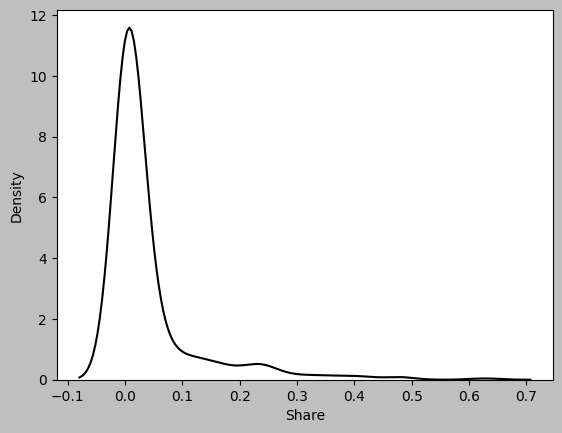

In [397]:
sns.kdeplot(df['Share'])

In [398]:
from matplotlib import style
style.use('seaborn-v0_8-bright')

In [394]:
style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']